#Capstone Project - The Battle of the Neighborhoods

This is the final project for the Applied Data Science Capstone by IBM & Coursera

###Table of Contents

* [Business Problem and Data](#week1)
   * [Business Problem](#problem)
   * [Data](#data)

* [Analysis](#week2)
   * [Methodology](#methodology)
   * [Data](#data)
   * [Results and Discussion](#results)
   * [Conclusion](#conclusion)

##Business problem and required data <a name="week1"></a>

###Business Problem <a name="problem"></a>

The first and also one of the most crucial steps in opening up a new venue, such as a restaurant or super market, is to find a suitable location for the new venue. This problem holds true for any kind of venue, that is dependent on customers and competition. Solving this problem is therefore of high interest to everyone, who is thinking about opening up a new venue.

For this project I will try to solve this location problem for one particular kind of venue, namely by finding the best possible location to open up a new **ice-cream shop** in Berlin, Germany.

In order to decide if a location is suitable, I will focus on the following conditions:

* I will try to find a location that has a **lot of food related venues**, indicating that the location is frequented by a lot of people looking for something to eat. However, there should be little or **no ice-cream shops** in the vicinity of the location, in order to reduce competition, when opening up the new venue.

* An additional condition on finding a suitable location, will be the **distance to the city center**. First of all there are more people in the center of Berlin due to denser population and second, there are also more tourists around. Both adding further to the number of potential customers.

###Data <a name="data"></a>

Instead of resorting to the different neighborhoods in Berlin, which vary heavily in size, I will resort to using evenly sized areas.
The size of each area as well as the total area of interest, will be defined in a later stage.

Given the business problem, we need the following **data points** for each area, to find suitable locations for opening up an ice-cream shop:

* Number of other food related venues (*Attractiveness of the area*)
* Number of ice-cream shops and distance from the location (*Competition in the area*)
* Distance of the location to the city center (*Number of potential customers*)  

\
**Data Sources**  

The following data sources will be used in the course of this project:
* Venue data (venue location, number and type of venue) will be provided by the *Foursquare API* 
* Geospatial data will be taken from different providers, such as *geocoder.ca*
* Geolocation of the city center of Berlin will be taken from *Wikipedia*

---

##Analysis <a name="week2"></a>

###Methodology <a name=methodology></a>

Get a better understanding of the place that we want to take a look at

1. Define location areas centered around the city center of Berlin
   1. Get geolocation of city center
   2. Decide on size of our total area of interest as well as our location areas
   3. Get center (geolocation) of the location areas, while making sure they are evenly spaced across our total area
   4. Make sure location areas overlap enough to cover every area within our total area
2. Plot those location areas using Folium

Fill the location areas with venues of interest (all food-related venues and ice-cream shops) within the respective vicinity
1. Access FourSquare API and get 100 venues for each location are that matches the prerequisites
2. Create data frame that contains each location are along with respective venues

In [0]:
#Importing relevant libraries
import requests
from bs4 import BeautifulSoup
import folium
import pandas as pd
import math

The geolocation of the Berlin city center will be scraped from the Berlin Wikipedia entry, using BeautifulSoup.

In [0]:
#Reading the url

url = 'https://de.wikipedia.org/wiki/Berlin'

wiki_berlin = website = requests.get(url).text

In [0]:
#Turning website source code into a readable format

soup = BeautifulSoup(wiki_berlin, 'lxml')
print(soup.prettify())

#Finding the wikitable containing the geolocation data
x = soup.find('table',{'class':'wikitable toptextcells float-right'})

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="de">
 <head>
  <meta charset="utf-8"/>
  <title>
   Berlin – Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":[",\t.",".\t,"],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","Januar","Februar","März","April","Mai","Juni","Juli","August","September","Oktober","November","Dezember"],"wgMonthNamesShort":["","Jan.","Feb.","Mär.","Apr.","Mai","Jun.","Jul.","Aug.","Sep.","Okt.","Nov.","Dez."],"wgRequestId":"XmL6wApAAEMAAAR3rIYAAABH","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Berlin","wgTitle":"Berlin","wgCurRevisionId":197453860,"wgRevisionId":197453860,"wgArticleId":2552494,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Wikipedia:Gesprochener Artikel","Wikipedia:Lesenswert","Berlin","Bundes

In [0]:
#Scraping the latitude and longitude for Berlin out of the wikitable

lat_ber = x.find('span', {'class':'latitude'}).text
long_ber = x.find('span', {'class':'longitude'}).text

print('The geolocation of the Berlin city center is {}, {}.'.format(lat_ber, long_ber))

The geolocation of the Berlin city center is 52.518611111111, 13.408333333333.


Now that we have the geospatial location of the Berlin city center, we can plot it, along with a circle indicating the area of interest for the analysis (11km radius around the center).

In [0]:
#Plotting a map of Berlin with the location of the city center

ber_center = [float(lat_ber), float(long_ber)]

ber_map = folium.Map(location=ber_center, zoom_start=12)

#Adding a marker for the City Center
folium.Marker(
    ber_center, 'City Center'
).add_to(ber_map)

#Showing the total area of interest for our analysis
folium.Circle(ber_center, radius=11000,
                    popup='Total area', line_color='#3186cc',
                    fill_color='#3186cc').add_to(ber_map)

ber_map

This map is quite empty, let's change that. Now that the center of the analysis is known, the location areas can be build around the city center.

Before building the location areas, the radius of the location areas has to be defined. In order to chose a radius, I came up with the following criteria: \

  **Each venue within a location area should be within walking distance from all the other venues in that area.**

To meet this criteria, I chose a radius of 300 meters, which translate to a maximum distance between two venues of 600 meters. This seems to be a reasonable distance, that someone would be willing to walk for some ice-cream.

In [0]:
#Setting the location area radius to 300 meters
loc_rad = 300

In [0]:
#Creating a function for calculating latitude and longitude flr a new point, by going from a start point in a certain direction and distance

import geopy
import geopy.distance

def calc_dist(start, dist, bear):

  #Setting the start point
  start = geopy.Point(start[0], start[1])

  #Creating a distance object, with a distance equal to dist
  dist = geopy.distance.GreatCircleDistance(kilometers = dist)
  
  #Using destination method, to go from start a distance dist in a certain direction (bearing)
  dist = dist.destination(point = start, bearing = bear)

  #Returning latitude and longitude of the point
  return([dist.latitude, dist.longitude])

In [0]:
#Calculating the center for every location area
y_off = math.sqrt(3) / 2

list_x = []

for i in range(1, 33):
  for j in range(0, i*4):
    x = calc_dist(ber_center, i * 0.420 * y_off, 360/(i * 4 + i * 4 * i%2) * j )
    list_x.append(x)

Let's see with how many location areas we ended up with.

In [0]:
#Getting the number of location areas
print('There are {} locations areas within our predefined area around the Berlin city center'.format(len(list_x)))

There are 2112 locations areas within our predefined area around the Berlin city center


That is quite a lot of 'neighborhoods'. Let us take a first look at them, by plotting them on our map of Berlin.

In [0]:
#Plotting our location areas

ber_map = folium.Map(location=ber_center, zoom_start=11)

#Adding a marker for the center of Berlin
folium.Marker(ber_center, 'City Center').add_to(ber_map)
for x in list_x:
  #Creating circles for each neighborhood and adding them to the map
  folium.Circle(x, fill=True,
        radius=loc_rad,
        color='black',
        fill_color=False).add_to(ber_map)

#Adding a circle with a radius of 12km to show the total area of interest
folium.Circle(ber_center, radius=12000,
                    popup='Total area', line_color='#3186cc',
                    fill_color=False).add_to(ber_map)

ber_map  

The different location areas are overlapping to make sure, that no venue is left out. 
Having a venue in one more than one location area, is unproblematic, since the goal is to find the location area that suits our problem best.

For the analysis we will need the centers of our location areas, therefore I will put them into a dataframe. Additionally, each location area will be assigned a number for later reference.

In [0]:
#Creating a Pandas data frame out of the geospatial data
locations = pd.DataFrame(list_x)

locations.columns = ['Lat', 'Long']

locations['Area'] = list(range(0,len(locations)))

locations.head()

Lat       Long  Area
0  52.521882  13.408333     0
1  52.518611  13.413709     1
2  52.515340  13.408333     2
3  52.518611  13.402958     3
4  52.525153  13.408333     4

####FourSquare



Now that I have created the set of location areas, it is time to find the venues within each area.

As a reminder, the venues of interest are:
- All **food** related venues
- **Ice cream shops** in each location area, since that is the kind of venue we are interested in potentially opening



The categories 'Food' (category ID: 4d4b7105d754a06374d81259) and 'Ice Cream Shop' (category ID: 4bf58dd8d48988d1c9941735) are the ones that I will be using. The match our two sets of venues of interest. 

*Further IDs can be found here:* \
- *List of all FourSquare venue categories: https://developer.foursquare.com/docs/resources/categories*

In [0]:
#FourSquare Credentials

CLIENT_ID = '---'
CLIENT_SECRET = '---'
version = '20180604'
categoryID = '4d4b7105d754a06374d81259' #ID for the food category
catID = '4bf58dd8d48988d1c9941735' #ID for IceCream Parlors

In [0]:
#Setting the parameters for the API calls
radius = loc_rad
limit = 50 #limit given by the FourSquare API
venue_count = 100

Calling the FourSquare API to get the food-related venues for every location area and putting them into a data frame:

In [0]:
#Creating an empty dataframe
venues = pd.DataFrame(columns = ['Area', 'Lat', 'Long', 'Name', 'Category', 'Summary'])

#Calling the API for every location area

for i in range(0, len(locations)):
  valid = False
  while not valid: #Error handling to make sure, the API calls are made for each location area
    try:
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          version,
          locations.Lat[i],
          locations.Long[i],
          radius, 
          limit,
          categoryID)
      results = requests.get(url).json()
      result_count = len(results['response']['groups'][0]['items'])
      valid=True
    except:
      pass

  #Adding the venues with name, category and location to the venues dataframe
  for j in range(0,result_count):
    area = i
    name = results['response']['groups'][0]['items'][j]['venue']['name']
    category = results['response']['groups'][0]['items'][j]['venue']['categories'][0]['name']
    lat = results['response']['groups'][0]['items'][j]['venue']['location']['lat']
    lng = results['response']['groups'][0]['items'][j]['venue']['location']['lng']
    summary = results['response']['groups'][0]['items'][j]['reasons']['items'][0]['summary']
    new_row = pd.Series([area, lat, lng, name, category, summary], index=['Area', 'Lat', 'Long', 'Name', 'Category', 'Summary'])
    venues = venues.append(new_row, ignore_index=True)

Taking a look at the number of venues within the location areas (might contain duplicates, due to overlapping areas):

In [0]:
print('There is a total of {} venues.'.format(venues.shape[0]))

There is a total of 8443 venues.


But, are there venues in each one of the location areas?

In [0]:
print('Total number of location areas:', len(locations))
print('Location areas with at least 1 venue:',len(venues.iloc[:,0].unique()))
print('Location areas without venues:', len(locations)-len(venues.iloc[:,0].unique()), '({:.2f}%)'.format(100*(len(locations)-len(venues.iloc[:,0].unique()))/len(locations)))

Total number of location areas: 2112
Location areas with at least 1 venue: 1328
Location areas without venues: 784 (37.12%)


Seems like there are quite a lot of location areas without any venues. \
This is most likely due to location areas that spread across bodies of water, commercial districts or forests.

Plotting the venues on the Berlin map, to get a first visual impression of the distribution. \
*Note: They are clustered by geographical proximity to each other in order to have a better overview. These are **NOT** the final clusters, used in the analysis.*

In [0]:
from folium.plugins import FastMarkerCluster

#Plotting the newly found venues on our Berlin map

ber_map = folium.Map(location=ber_center, zoom_start=12)

#Clustering the venues to have a better overview
ber_map.add_child(FastMarkerCluster(venues[['Lat','Long']].values.tolist()))

ber_map

Now that the first part of the FourSquare data has been acquired, I now need to get all the Ice Cream Shops within the different location areas. The loop for calling the FourSquare API is almost the same as before, except that I will use a different categoryID.

In [0]:
#Creating an empty dataframe
icecream_shops = pd.DataFrame(columns = ['Area', 'Lat', 'Long', 'Name', 'Category', 'Summary'])

#Calling the API for every location area

for i in range(0, len(locations)):
  valid = False
  while not valid: #Error handling to make sure, the API calls are made for each location area
    try:
      url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          version,
          locations.Lat[i],
          locations.Long[i],
          radius, 
          limit,
          catID)
      results = requests.get(url).json()
      result_count = len(results['response']['groups'][0]['items'])
      valid=True
    except:
      pass

  #Adding the Icecream Shops with name, category and location to the Icecream Shops dataframe
  for j in range(0,result_count):
    area = i
    name = results['response']['groups'][0]['items'][j]['venue']['name']
    category = results['response']['groups'][0]['items'][j]['venue']['categories'][0]['name']
    lat = results['response']['groups'][0]['items'][j]['venue']['location']['lat']
    lng = results['response']['groups'][0]['items'][j]['venue']['location']['lng']
    summary = results['response']['groups'][0]['items'][j]['reasons']['items'][0]['summary']
    new_row = pd.Series([area, lat, lng, name, category, summary], index=['Area', 'Lat', 'Long', 'Name', 'Category', 'Summary'])
    icecream_shops = icecream_shops.append(new_row, ignore_index=True)

Taking a first look at the Ice Cream Shop dataframe and cleaning it.

In [0]:
#Number of Ice Cream Shops

#Total number of venues on the Ice Cream Shop dataframe
len(icecream_shops)

#Actual Ice Cream Shops
sum(icecream_shops['Category'] == 'Ice Cream Shop')

#Delta
delta = len(icecream_shops) - sum(icecream_shops['Category'] == 'Ice Cream Shop')
print('Looks like there are {} venues in the dataframe that are not primarily ice cream shops.'.format(delta))

Looks like there are 81 venues in the dataframe that are not primarily ice cream shops.


The reason is probably, that both the Dessert Shop category and the Ice Cream Shop category have the same categoryID *4bf58dd8d48988d1d0941735* (see also: https://developer.foursquare.com/docs/resources/categories).

Since I only want Ice Cream Shops in the dataframe, I will clean the dataframe and drop all other venues.

In [0]:
#Dropping everything but Ice Cream Shops from the dataframe
icecream_shops2 = icecream_shops

icecream_df = icecream_shops.drop(icecream_shops2[icecream_shops2['Category'] != 'Ice Cream Shop'].index, axis = 0).reset_index()
icecream_df = icecream_df.drop(columns=['index'], axis=1)

print('There is a total of {} ice cream shops across the location areas.'.format(icecream_df.shape[0]))
icecream_df.head()

There is a total of 661 ice cream shops across the location areas.


Area        Lat  ...        Category               Summary
0     0  52.520342  ...  Ice Cream Shop  This spot is popular
1     0  52.522237  ...  Ice Cream Shop  This spot is popular
2     0  52.521236  ...  Ice Cream Shop  This spot is popular
3     0  52.523035  ...  Ice Cream Shop  This spot is popular
4     0  52.521531  ...  Ice Cream Shop  This spot is popular

[5 rows x 6 columns]

Now I am only left with ice cream shops. However, there might be some duplicates among them, since our location areas are overlapping.

In [0]:
#Finding the unique ice cream shops
ice_unique = icecream_df[['Lat', 'Long', 'Name', 'Category', 'Summary']]

ice_unique = ice_unique.drop_duplicates()

unique_count = len(ice_unique)
print('Out of the {} ice cream shops across all the location areas, there are {} unique shops.'.format(icecream_df.shape[0],unique_count))
print()
print('Location areas with at least 1 ice cream shop:',len(icecream_df.iloc[:,0].unique()))
print('Location areas without ice cream shops:', len(locations)-len(icecream_df.iloc[:,0].unique()), '({:.2f}%)'.format(100*(len(locations)-len(icecream_df.iloc[:,0].unique()))/len(locations)))

Out of the 661 ice cream shops across all the location areas, there are 492 unique shops.

Location areas with at least 1 ice cream shop: 374
Location areas without ice cream shops: 1738 (82.29%)


Having cleaned the Ice Cream Shop Dataframe, I end up with a total of 661 Ice Cream Shops for all the location areas, of which 492 are unique.
To get a first impression of their location and distribution across Berlin, I will plot them on the Berlin map using Folium.

In [0]:
#Plotting the unique Ice Cream Shops on our Berlin map

ber_map = folium.Map(location=ber_center, zoom_start=12)

folium.Marker(ber_center, 'City Center').add_to(ber_map)
for x, y in zip(zip(ice_unique['Lat'], ice_unique['Long']), ice_unique['Name']):
  folium.Marker(x,
        popup = y).add_to(ber_map)

ber_map

Wow, that is quite a lot of ice cream shops, let's hope we'll find a place, where we can snuck our new shop in.

In order to use the venues dataframe for a k-means algorithm and cluster the location areas, the dataframe needs to be prepared first. I will be using one-hot-encoding to do so.

In [0]:
#One Hot Encoding to be able to use k-means algorithm

berlin_onehot = pd.get_dummies(venues['Category'], prefix="", prefix_sep="")

print(berlin_onehot.shape)
print()
berlin_onehot.head()

(8443, 139)



African Restaurant  American Restaurant  ...  Wings Joint  Yemeni Restaurant
0                   0                    0  ...            0                  0
1                   0                    0  ...            0                  0
2                   0                    0  ...            0                  0
3                   0                    0  ...            0                  0
4                   0                    0  ...            0                  0

[5 rows x 139 columns]

In [0]:
#Adding the one hot encoded venue categories to the neighborhood data to create a complete data set

venue_fulldat = venues.iloc[:,0].to_frame()

for col in berlin_onehot.columns:
    venue_fulldat[col] = berlin_onehot[col]


#Take a look at our full data set
print(venue_fulldat.shape) 
print()
venue_fulldat.head()

(8443, 140)



Area  African Restaurant  ...  Wings Joint  Yemeni Restaurant
0     0                   0  ...            0                  0
1     0                   0  ...            0                  0
2     0                   0  ...            0                  0
3     0                   0  ...            0                  0
4     0                   0  ...            0                  0

[5 rows x 140 columns]

Let's see how many venues there are within each location area.

In [0]:
#Creating dataframe that aggregates across venues for each location area
venue_type_count = venue_fulldat.groupby('Area').sum().reset_index()

venue_type_count['No_venues'] = venue_type_count.iloc[:,1:144].sum(axis=1)

In [0]:
#Grouping by location area and calculating ratio for each venue type
venues_grouped = venue_fulldat.groupby('Area').mean().reset_index()

#Adding the number of venues to the toronto_fulldat dataframe
venues_grouped.insert(1, 'No_venues', venue_type_count['No_venues'])

print(venues_grouped.shape)
print()
venues_grouped.head()

(1328, 141)



Area  No_venues  ...  Wings Joint  Yemeni Restaurant
0     0         50  ...          0.0                0.0
1     1         39  ...          0.0                0.0
2     2         12  ...          0.0                0.0
3     3         33  ...          0.0                0.0
4     4         49  ...          0.0                0.0

[5 rows x 141 columns]

Now that the data has been prepared, the location areas can be clustered, using a k-means algorithm. 

###Clustering

Having aggregated and prepared all the necessary data about the location areas, we can now move on to clustering them. To do so, I will use a k-means algorithm. In order to determine the best value for k, I will facilitate the Silhouette Score.
\
The idea behind the clustering, is to find location that are similiar to each other. Having found similar location areas, we can then look at the number of ice cream shops in each location areas. Having location areas with and without ice cream shops in the same cluster, we can take those without as ideal candidates for opening up a new ice cream shop. Knowing that it worked in similar location areas.

In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [0]:
#Getting the cluster sizes for different numbers of cluster and calculating the Silhouette Score for each cluster

print('Clusters and their respective size')
print()

for k in range(2,21):
  venues_grouped_clusters = venues_grouped.drop(['Area','No_venues'], 1)

  #Run the k-means clustering algorithm
  kmeans = KMeans(n_clusters = k, random_state = 3).fit(venues_grouped_clusters)
  print('--- k = {} --- Share --- Mean Silhouette Score ---'.format(k))
  for i in range(0,k):
    silhoutte_cluster = (silhouette_samples(venues_grouped_clusters, kmeans.labels_)[kmeans.labels_ == i]).mean()
    print('Cluster {}:'.format(i), sum(kmeans.labels_ == i), '({0:.2f}%)'.format(100*sum(kmeans.labels_ == i)/len(kmeans.labels_)), '--- {0:.2f}'.format(silhoutte_cluster))
  print('--- --- --- --- ---')
  print('Silhouette Score:', silhouette_score(venues_grouped_clusters, kmeans.labels_))
  print()

Clusters and their respective size

--- k = 2 --- Share --- Mean Silhouette Score ---
Cluster 0: 1137 (85.62%) --- 0.07
Cluster 1: 191 (14.38%) --- 0.36
--- --- --- --- ---
Silhouette Score: 0.1106154834808318

--- k = 3 --- Share --- Mean Silhouette Score ---
Cluster 0: 164 (12.35%) --- 0.39
Cluster 1: 115 (8.66%) --- 0.42
Cluster 2: 1049 (78.99%) --- 0.06
--- --- --- --- ---
Silhouette Score: 0.13339376443374634

--- k = 4 --- Share --- Mean Silhouette Score ---
Cluster 0: 101 (7.61%) --- 0.46
Cluster 1: 64 (4.82%) --- 0.57
Cluster 2: 992 (74.70%) --- 0.07
Cluster 3: 171 (12.88%) --- 0.36
--- --- --- --- ---
Silhouette Score: 0.16197470185188845

--- k = 5 --- Share --- Mean Silhouette Score ---
Cluster 0: 64 (4.82%) --- 0.56
Cluster 1: 80 (6.02%) --- 0.19
Cluster 2: 914 (68.83%) --- 0.09
Cluster 3: 171 (12.88%) --- 0.35
Cluster 4: 99 (7.45%) --- 0.46
--- --- --- --- ---
Silhouette Score: 0.18140661839141203

--- k = 6 --- Share --- Mean Silhouette Score ---
Cluster 0: 63 (4.74%) ---

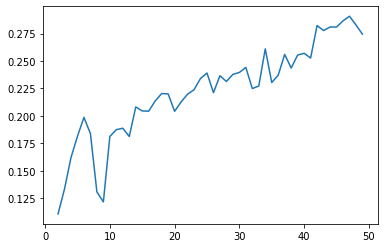

The highest silhouette score 0.2907873469965384 is achieved with a k of 47.


In [0]:
#Plotting the Silhouette Score for the different values of k

import matplotlib.pyplot as plt

x = list()
y = list()

for k in range(2,50):
  venues_grouped_clusters = venues_grouped.drop(['Area','No_venues'], 1)

  #Run the k-means clustering algorithm
  kmeans = KMeans(n_clusters = k, random_state = 3).fit(venues_grouped_clusters)
  score = silhouette_score(venues_grouped_clusters, kmeans.labels_)
  x.append(k)
  y.append(score)

plt.plot(x, y)
plt.show()

highest_silhouette = max(y)
best_k = x[y.index(max(y))]

print('The highest silhouette score {} is achieved with a k of {}.'.format(highest_silhouette, best_k))

Let's take a look at the clusters with the best k, which in this case is 47.

In [0]:
#Run the k-means clustering algorithm
kmeans = KMeans(n_clusters = best_k, random_state = 3).fit(venues_grouped_clusters)
print('--- k = {} --- Share --- Mean Silhouette Score ---'.format(best_k))

for i in range(0,best_k):
  silhoutte_cluster = (silhouette_samples(venues_grouped_clusters, kmeans.labels_)[kmeans.labels_ == i]).mean()
  print('Cluster {}:'.format(i), sum(kmeans.labels_ == i), '({0:.2f}%)'.format(100*sum(kmeans.labels_ == i)/len(kmeans.labels_)), '--- {0:.2f}'.format(silhoutte_cluster))
print('--- --- --- --- ---')
print('Silhouette Score: {0:.4f}'.format(silhouette_score(venues_grouped_clusters, kmeans.labels_)))
print()

--- k = 47 --- Share --- Mean Silhouette Score ---
Cluster 0: 81 (6.10%) --- 0.12
Cluster 1: 10 (0.75%) --- 0.19
Cluster 2: 5 (0.38%) --- 0.39
Cluster 3: 65 (4.89%) --- -0.25
Cluster 4: 49 (3.69%) --- 0.94
Cluster 5: 60 (4.52%) --- 0.84
Cluster 6: 15 (1.13%) --- 1.00
Cluster 7: 25 (1.88%) --- 0.96
Cluster 8: 49 (3.69%) --- -0.04
Cluster 9: 13 (0.98%) --- 1.00
Cluster 10: 21 (1.58%) --- 0.95
Cluster 11: 41 (3.09%) --- 0.94
Cluster 12: 260 (19.58%) --- 0.22
Cluster 13: 9 (0.68%) --- 0.51
Cluster 14: 32 (2.41%) --- -0.03
Cluster 15: 16 (1.20%) --- -0.09
Cluster 16: 11 (0.83%) --- 0.11
Cluster 17: 26 (1.96%) --- 0.17
Cluster 18: 24 (1.81%) --- 0.95
Cluster 19: 11 (0.83%) --- 1.00
Cluster 20: 33 (2.48%) --- -0.05
Cluster 21: 5 (0.38%) --- 1.00
Cluster 22: 5 (0.38%) --- 1.00
Cluster 23: 7 (0.53%) --- 1.00
Cluster 24: 61 (4.59%) --- -0.03
Cluster 25: 110 (8.28%) --- -0.02
Cluster 26: 4 (0.30%) --- 0.61
Cluster 27: 3 (0.23%) --- 1.00
Cluster 28: 48 (3.61%) --- 0.10
Cluster 29: 3 (0.23%) --- 1.

In [0]:
#Add the clustering labels
venues_grouped_clusters.insert(0, 'Cluster Labels', kmeans.labels_)

#Adding the area number and no of venues
venues_grouped_clusters.insert(1, 'Area', venues_grouped['Area'])
venues_grouped_clusters.insert(2, 'No_venues', venues_grouped['No_venues'])

venues_grouped_clusters.head()

Cluster Labels  Area  ...  Wings Joint  Yemeni Restaurant
0              12     0  ...          0.0                0.0
1              12     1  ...          0.0                0.0
2              24     2  ...          0.0                0.0
3              24     3  ...          0.0                0.0
4              12     4  ...          0.0                0.0

[5 rows x 142 columns]

For the further course of the analysis, I will also need to add the number of ice cream shops for each location. This is necessary to determine the number of ice cream shops in each cluster and to see which location area has and which doesn't have an ice cream shop yet.

In [0]:
#Getting the number of ice cream shops in each location area
icecream_df2 = icecream_df
icecream_df2 = icecream_df2.groupby('Area').count().reset_index()

icecream_df2.head()

Area  Lat  Long  Name  Category  Summary
0     0    5     5     5         5        5
1     1    4     4     4         4        4
2     3    3     3     3         3        3
3     4    2     2     2         2        2
4     5    1     1     1         1        1

In [0]:
#Adding the number of ice cream shops for each area location
venues_grouped_clusters['IceCreamShops'] = venues_grouped_clusters['Area'].map(icecream_df2.set_index('Area')['Summary'])

venues_grouped_clusters.insert(1, 'No_IceCreamShops', venues_grouped_clusters['IceCreamShops'])

venues_grouped_clusters = venues_grouped_clusters.drop(['IceCreamShops'], axis=1)

venues_grouped_clusters = venues_grouped_clusters.fillna(0)

venues_grouped_clusters.head()

Cluster Labels  No_IceCreamShops  ...  Wings Joint  Yemeni Restaurant
0              12               5.0  ...          0.0                0.0
1              12               4.0  ...          0.0                0.0
2              24               0.0  ...          0.0                0.0
3              24               3.0  ...          0.0                0.0
4              12               2.0  ...          0.0                0.0

[5 rows x 143 columns]

Now that we adding the number of ice cream shops in each location area, it is time to get the total number of ice cream shops in each cluster. Furthermore, I will identify those clusters that have less than 5 ice cream shops, since those will not be relevant for the further cause of the analysis.


In [0]:
#List to catch all clusters with less than 5 ice cream shops in total
to_few = []

for i in range(0, best_k):
  no_ice_shops = sum(venues_grouped_clusters[venues_grouped_clusters['Cluster Labels'] == i]['No_IceCreamShops'])
  no_areas = len(venues_grouped_clusters[venues_grouped_clusters['Cluster Labels'] == i]['No_IceCreamShops'])
  if no_ice_shops < 5:
    to_few.append(i)
  print('Cluster {} has {} ice cream shops and {} location areas.'.format(i, no_ice_shops, no_areas))

Cluster 0 has 26.0 ice cream shops and 81 location areas.
Cluster 1 has 1.0 ice cream shops and 10 location areas.
Cluster 2 has 0.0 ice cream shops and 5 location areas.
Cluster 3 has 27.0 ice cream shops and 65 location areas.
Cluster 4 has 0.0 ice cream shops and 49 location areas.
Cluster 5 has 4.0 ice cream shops and 60 location areas.
Cluster 6 has 0.0 ice cream shops and 15 location areas.
Cluster 7 has 1.0 ice cream shops and 25 location areas.
Cluster 8 has 12.0 ice cream shops and 49 location areas.
Cluster 9 has 3.0 ice cream shops and 13 location areas.
Cluster 10 has 0.0 ice cream shops and 21 location areas.
Cluster 11 has 4.0 ice cream shops and 41 location areas.
Cluster 12 has 409.0 ice cream shops and 260 location areas.
Cluster 13 has 0.0 ice cream shops and 9 location areas.
Cluster 14 has 12.0 ice cream shops and 32 location areas.
Cluster 15 has 2.0 ice cream shops and 16 location areas.
Cluster 16 has 1.0 ice cream shops and 11 location areas.
Cluster 17 has 10.0

Cluster that have no or little ice cream shops are not really interesting, since there is probably a reason, that almost none of the location areas in that cluster have an ice cream shop already. \
Interesting are those clusters that have location areas with multiple ice cream shops. \
For the remainder of the analysis I will therefore only take a look at those clusters, that have at least 5 or more ice cream shops (Identified in the step above).

In [0]:
venues_grouped_clusters2 = venues_grouped_clusters

venues_grouped_clusters2 = venues_grouped_clusters2[~venues_grouped_clusters2['Cluster Labels'].isin(to_few)]

venues_grouped_clusters2.head()

Cluster Labels  No_IceCreamShops  ...  Wings Joint  Yemeni Restaurant
0              12               5.0  ...          0.0                0.0
1              12               4.0  ...          0.0                0.0
2              24               0.0  ...          0.0                0.0
3              24               3.0  ...          0.0                0.0
4              12               2.0  ...          0.0                0.0

[5 rows x 143 columns]

In [0]:
#Print the clusters that have at least 5 ice cream shops

for i in venues_grouped_clusters2['Cluster Labels'].unique():
  no_ice_shops = sum(venues_grouped_clusters2[venues_grouped_clusters2['Cluster Labels'] == i]['No_IceCreamShops'])
  no_areas = len(venues_grouped_clusters2[venues_grouped_clusters2['Cluster Labels'] == i]['No_IceCreamShops'])
  print('Cluster {} has {} ice cream shops and {} location areas, which makes on average {} ice cream shops.'.format(i, no_ice_shops, no_areas, no_ice_shops/no_areas))

Cluster 12 has 409.0 ice cream shops and 260 location areas, which makes on average 1.573076923076923 ice cream shops.
Cluster 24 has 19.0 ice cream shops and 61 location areas, which makes on average 0.3114754098360656 ice cream shops.
Cluster 3 has 27.0 ice cream shops and 65 location areas, which makes on average 0.4153846153846154 ice cream shops.
Cluster 8 has 12.0 ice cream shops and 49 location areas, which makes on average 0.24489795918367346 ice cream shops.
Cluster 25 has 36.0 ice cream shops and 110 location areas, which makes on average 0.32727272727272727 ice cream shops.
Cluster 14 has 12.0 ice cream shops and 32 location areas, which makes on average 0.375 ice cream shops.
Cluster 20 has 10.0 ice cream shops and 33 location areas, which makes on average 0.30303030303030304 ice cream shops.
Cluster 0 has 26.0 ice cream shops and 81 location areas, which makes on average 0.32098765432098764 ice cream shops.
Cluster 36 has 18.0 ice cream shops and 59 location areas, which m

Out of the original 47 clusters, only 13 remain with 5 or more ice cream shops.

Cluster 12 seems to be the most promising one, since there is on average at least one ice cream shop in each location area.
I will therefore focus on cluster 12 and and take a closer look at the location areas within, to see if there is potential for a new ice cream shop.

In [0]:
#Creating a datframe for Cluster 12
cluster12 = venues_grouped_clusters2[venues_grouped_clusters2['Cluster Labels'] == 12]

print('There are {} location areas out of the total {} without an ice cream shop.'.format(sum(cluster12['No_IceCreamShops'] == 0),len(cluster12)))

There are 77 location areas out of the total 260 without an ice cream shop.


Plotting the location areas that have a potential for opening up a new ice cream shop.

In [0]:
#Creating a dataset with all location areas from cluster 12 that have no ice cream shop yet
potential_locations = cluster12[cluster12['No_IceCreamShops'] == 0]

potential_locations = potential_locations.set_index('Area').join(locations.set_index('Area')).reset_index()

potential_locations = potential_locations[['Area', 'Lat', 'Long']]

potential_locations.head()

Area        Lat       Long
0     7  52.513985  13.415935
1     8  52.512069  13.408333
2    17  52.510112  13.416395
3    18  52.508798  13.408333
4    22  52.523517  13.394365

In [0]:
#Plotting our location areas

ber_map = folium.Map(location=ber_center, zoom_start=11)

#Adding a marker for the center of Berlin
folium.Marker(ber_center, 'City Center').add_to(ber_map)
for x in zip(potential_locations['Lat'], potential_locations['Long']):
  #Creating circles for each neighborhood and adding them to the map
  folium.Circle(x, fill=True,
        radius=loc_rad,
        color='black',
        fill_color=False).add_to(ber_map)

#Adding a circle with a radius of 12km to show the total area of interest
folium.Circle(ber_center, radius=12000,
                    popup='Total area', line_color='#3186cc',
                    fill_color=False).add_to(ber_map)

ber_map  

Compared to the initial map of the location areas, the location areas have been greatly reduced to only those that offer potential for opening up a new ice cream shop.

The final step in the analysis will be to rank the location areas by their distance to the city center of Berlin. With shorter distance to the city center being preferable to a farther distance to the center.

In [0]:
#Calculating the distance from each location area center to the city center
center_dist = []

for i in zip(potential_locations['Lat'], potential_locations['Long']):
  coords_1 = (i[0], i[1])
  coords_2 = (ber_center[0], ber_center[1])
  center_dist.append(geopy.distance.vincenty(coords_1, coords_2).km)

#Adding the distance to our dataframe with potential locations
potential_locations['Center_dist'] = center_dist


#Sorting the potential locations by their distance to the city center
potential_locations.sort_values(by=['Center_dist']).reset_index(drop=True)

potential_locations.head()

Area        Lat       Long  Center_dist
0     7  52.513985  13.415935     0.728907
1     8  52.512069  13.408333     0.727998
2    17  52.510112  13.416395     1.092679
3    18  52.508798  13.408333     1.091997
4    22  52.523517  13.394365     1.094043

This final dataframe leaves us with a ranked table of location areas suitable for opening up a new ice cream shop in Berlin. 
The Top 5 location areas being 7, 8, 17, 18 and 22.

###Results & Discussion<a name="results"></a>

The analysis shows that, despite the large amount of **ice cream** shops in Berlin (~492 ice cream shops), there is still a lot of potential for opening up a new ice cream shops.

To find this potential and the right locations, Berlin was diveded into equally sized location areas, each with a radius of 300m. The location areas covered an area of 12km in diameter around the city center.

For each of the location areas, the current food related venues (including all restaurants, bars, etc. except dessert & ice cream shops) were acquired from **FourSquare** using their Places API. Number of food venues being used as a proxy for attractiveness of the location.
All location areas, where there were 0 venues, were dropped for the further course of the analysis.
In additon to the food related venues, I also scraped the existing ice cream shops in each location area.

The location areas where then clustered by the density and category of food venues in each location area, using a **k-means algorithm**. This resulted in a total of 47 clusters. For the further course of the analysis the clusters where enriched by the ice cream shops in each location area or cluster respectively.

The focus was then on the clusters where there was on average at least 1 ice cream shop per location area. This, however, was only the case for cluster 12, which then became the sole focus for the rest of the analysis.

Taking a look at the location areas within that cluster, revealed that there are 77 location areas in the cluster, that, despite an average of more than 1 ice cream shop per location, still have 0 ice cream shops.

Given that the other location areas in the same cluster, each have multiple ice cream shops, those 77 location areas seem to be quite promising, when it comes for finding a place to open up a new ice cream shop.

These location areas where then plotted, to show the potential for opening up a new ice cream shop in Berlin. 

In order to further prioritize the different location areas, the respective distance to the city center was calculated for each one of them. Being closer to the city center indicating a more faverable location (more traffic due to higher population density & tourists).

The final result is therefore a ranked list of 77 potential places to open up a new ice cream shop.

Despite, the fact, that these location areas are a good indicator, when it comes to opening up a new ice cream shop, further research, with additional data (such as financial data, age, etc.) should be done, before deciding on a final location.

###Conclusion <a name="conclusion"></a>

The idea behind this project, was to find locations in Berlin, that are suitable for opening up a new ice cream shop. \
It was done by segmenting Berlin into equally sized location areas, determining the food related venues in each area and using a k-means algorithm to cluster them. Furthermore, the existing ice cream shops in each location area and cluster, where used to determine the best suitable locations. 
Last but not least, the proximity to the city center was used to rank the set of potential locations. 
\
This analysis provides a first towards finding a suitable location, for opening up a new ice cream shop in Berlin.
In order to create a more sophisticated result, the analysis can be taken further and be enriched with additional data, such as income, age, etc. A final decision on where to open up a new ice cream shop, will therefore need to be made by the stakeholders themself.

Thanks for reading and I hope you've enjoyed my little project! :) 